# Fashion MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
mnist = fetch_openml('Fashion-MNIST', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.data.shape

(70000, 784)

In [ ]:
mnist.values()

dict_values([array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array(['9', '0', '0', ..., '8', '1', '5'], dtype=object), None, {}, ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pi

## Preprocessing Data


In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y, n=5):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:n].reshape(n, 28, 28), y[:n])):
        plt.figure(figsize=(1.5 * n, 1.5 * n))
        plt.subplot(1, n, 1 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

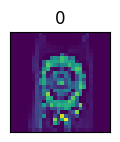

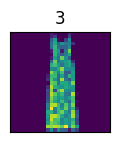

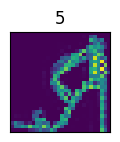

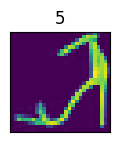

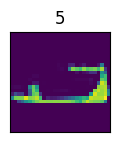

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:

torch.manual_seed(0)

module = Cnn()
cnn = NeuralNetClassifier(
    module,
    max_epochs=3,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
adversaries_x = torch.tensor(X_test).to(device)
adversaries_y = torch.tensor(y_test).to(device)
epsilon = 10 / 255

In [ ]:
step = 500
for i in range(10):
  adversaries_x = adversaries_x.to(device)
  cnn.fit(adversaries_x, adversaries_y)
  loss = nn.CrossEntropyLoss()
  inp = adversaries_x
  inp.requires_grad = True
  for j in range(0, inp.shape[0], step):
    module.eval()
    out = cnn.module(inp[j:j + step])
    loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))
    loss_val.backward()
    delta = epsilon * torch.sign(inp.grad.detach()[j:j + step])
    if j == 0:
      adversaries_x = torch.clamp(inp.detach()[j:j + step] + delta, 0.0, 1)
    else:
      adversaries_x = torch.cat((adversaries_x.detach(), torch.clamp(inp.detach()[j:j + step] + delta, 0.0, 1)), 0)
attacked = adversaries_x.cpu().detach().numpy()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0358       0.7677        0.5923  1.3684
      2        0.6546       0.7989        0.5081  1.0766
      3        0.5828       0.8203        0.4675  1.2197


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7774       0.7486        0.6188  1.1728
      2        0.6792       0.7803        0.5646  1.2735
      3        0.6332       0.8060        0.5120  0.9696


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8156       0.7263        0.6813  1.1813
      2        0.7241       0.7529        0.6140  2.4571
      3        0.6332       0.8160        0.4496  1.4258


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8515       0.7349        0.6717  0.9386
      2        0.6886       0.8151        0.4913  1.0197
      3        0.5240       0.8817        0.3502  0.8812


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0079       0.7129        0.7217  1.1652
      2        0.7187       0.8371        0.5014  1.1706
      3        0.5209       0.9126        0.2909  0.5880
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0352       0.7377        0.7058  0.5944
      2        0.7118       0.8220        0.5152  0.5825
      3        0.5394       0.9206        0.3056  0.5907


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0613       0.7066        0.7794  0.6989
      2        0.8005       0.8000        0.5886  0.7434
      3        0.6349       0.8840        0.3973  0.7556


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0743       0.7897        0.6256  1.0978
      2        0.6569       0.8909        0.3968  0.6105
      3        0.4848       0.9180        0.2778  0.5788
Re-initializing module.


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1634       0.6811        0.8690  0.5935
      2        0.8950       0.8049        0.6403  0.6001
      3        0.6904       0.8906        0.4120  0.5804


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8859       0.8754        0.4147  0.5860
      2        0.5194       0.9063        0.3055  0.5742
      3        0.4344       0.9137        0.2648  0.5801


<ipython-input-71-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


In [ ]:
mnist_dim = X.shape[1]
hidden_dims = [int(mnist_dim/8)]
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dims, output_dim

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net1.fit(X_train, y_train);
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9335       0.7359        0.6875  1.0870
      2        0.6190       0.7488        0.6166  1.0472
      3        0.5546       0.8241        0.4889  1.0361
      4        0.5163       0.8153        0.4946  1.2714
      5        0.4953       0.8270        0.4674  1.4835
      6        0.4776       0.8382        0.4376  1.0510
      7        0.4657       0.8145        0.4720  1.0244
      8        0.4569       0.8012        0.4983  1.0217
      9        0.4468       0.8256        0.4512  1.0280
     10        0.4373       0.8455        0.4122  1.0337
     11        0.4337       0.8429        0.4181  1.0126
     12        0.4244       0.8247        0.4464  1.0130
     13        0.4193       0.8476        0.4107  1.0132
     14        0.4153       0.8570        0.3922  1.0269
     15        0.4104       0.8574        0.3839  1.1591
     16        0.4047       0.8

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
y_pred = net1.predict(attacked)
accuracy_score(y_test, y_pred)

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
y_pred = net2.predict(attacked)
accuracy_score(y_test, y_pred)

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
y_pred = net3.predict(attacked)
accuracy_score(y_test, y_pred)

0.5331428571428571

In [ ]:
error_mask = y_pred != y_test

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
[mnist_dim//4, mnist_dim//2]

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.8676

In [ ]:
y_pred = net4.predict(attacked)
accuracy_score(y_test, y_pred)

0.5806857142857142

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3041       0.0998        2.3019  1.3129
      2        2.1595       0.2777        1.9645  1.2536
      3        1.6866       0.4684        1.5507  1.2452
      4        1.3642       0.5337        1.0450  1.2482
      5        1.2230       0.5290        1.0312  1.2431
      6        1.1566       0.3563        1.9225  1.2555
      7        1.2396       0.5590        1.1146  1.2598
      8        1.1109       0.5517        1.0588  1.7044
      9        1.0442       0.5732        0.8178  1.5743
     10        1.0044       0.6160        0.8692  1.2487
     11        0.9874       0.7355        0.6893  1.2413
     12        0.9665       0.6998        0.7072  1.2594
     13        0.9378       0.5607        1.2229  1.2694
     14        0.9339       0.6378        0.9210  1.2610
     15        0.9057       0.7673        0.6012  1.2507
     16        0.8857       0.7

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.7745714285714286

In [ ]:
y_pred = net1.predict(attacked)
accuracy_score(y_test, y_pred)

0.5949142857142857

# Convolutional Network


In [ ]:
XCnn = X.reshape(-1, 1, 28, 28)

In [ ]:
XCnn.shape

(70000, 1, 28, 28)

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7696       0.8181        0.4822  1.7682
      2        0.5248       0.8485        0.4088  1.6900
      3        0.4647       0.8738        0.3535  1.6431
      4        0.4256       0.8761        0.3385  1.7749
      5        0.4046       0.8820        0.3217  2.1149
      6        0.3864       0.8842        0.3157  1.6482
      7        0.3688       0.8911        0.2953  1.6517
      8        0.3616       0.8911        0.2979  1.6506
      9        0.3504       0.8936        0.2868  1.6750
     10        0.3380       0.8931        0.2845  1.6394


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.8990857142857143

In [ ]:
y_pred = net1.predict(attacked)
accuracy_score(y_test, y_pred)

0.5949142857142857

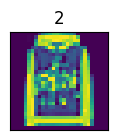

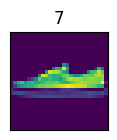

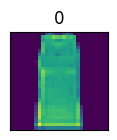

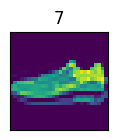

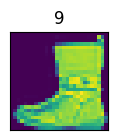

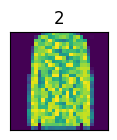

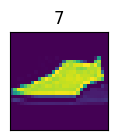

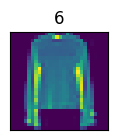

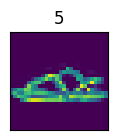

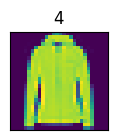

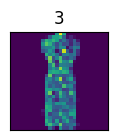

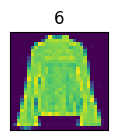

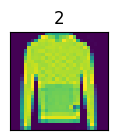

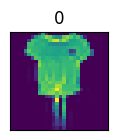

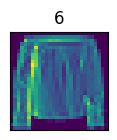

In [ ]:
plot_example(X_test, y_test, n=15)

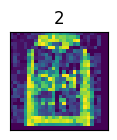

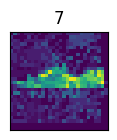

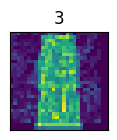

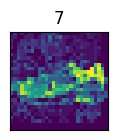

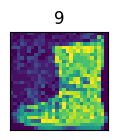

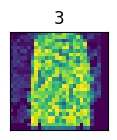

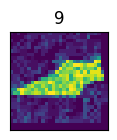

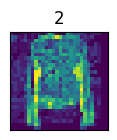

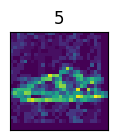

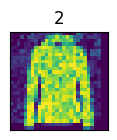

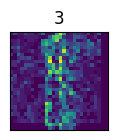

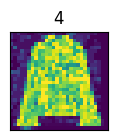

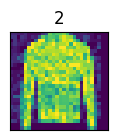

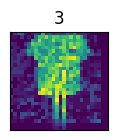

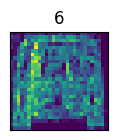

In [ ]:
plot_example(attacked, y_pred, n=15)